In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     |████████████████████████████████| 1.1MB 7.3MB/s 


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [4]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data
# 데이터의 3차원값을 추가한다. x,y좌표는 곡선을 생성하는 좌표이다.
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)
# 평균값을 제거하여 PCA를 진행한다.

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

#오토인코더의 기본적인 특성이다. 입력값과 출력값을 동일하게 해야한다.
#오토인코더 같은 경우에는 입력값을 복사한다는 개념이기 때문이다. 
#이 모델은 과소완전 선형 오토인코더
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

# 비용함수 정의에는 mse 방식으로 하는것으로 한다. PCA 개념이랑 비슷하다고 보면된다.

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=20)
#훈련을 하기위해서 target과 data를 동일하게 한다.

Epoch 1/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 3ms/step - loss: 0.

In [7]:
codings = encoder.predict(X_train)

In [23]:
codings.shape

(60, 2)

Saving figure linear_autoencoder_pca_plot


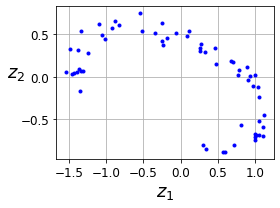

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

#pca와 유사하게 진행 인코더만 진행한것

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#이제 실제로 데이터를 적용해보자 데이터셋은 패션MNIST 데이터를 가지고 온다.

4423680/4422102 [==============================] - 0s 0us/step


In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
# 적층 오토인코더 28,28 하나로 펼친 후 100 -> 30?
# 적틍 오토디코더 100 -> 784로 활성화 함수로 selu, 마지막으로 시그모이드로 마무리
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))
#적층 오토인코더 훈련한다.

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9002
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2986 - rounded_accuracy: 0.9216 - val_loss: 0.2987 - val_rounded_accuracy: 0.9196
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

# 현재 이미지와 적층 오토인코더로 적용한 이미지 를 비교한다.      

Saving figure reconstruction_plot


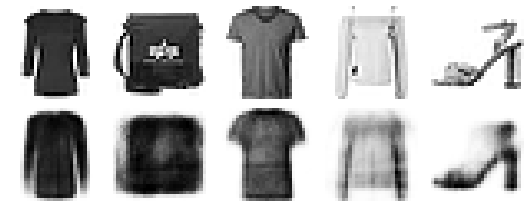

In [13]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

In [14]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

# t-SNE 확률적 임베딩을 통해서 PCA를 진행한다. 

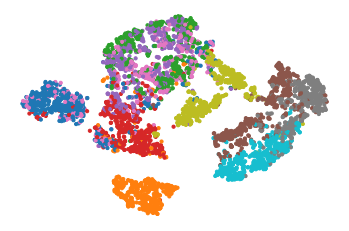

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

# 시각화 

Saving figure fashion_mnist_visualization_plot


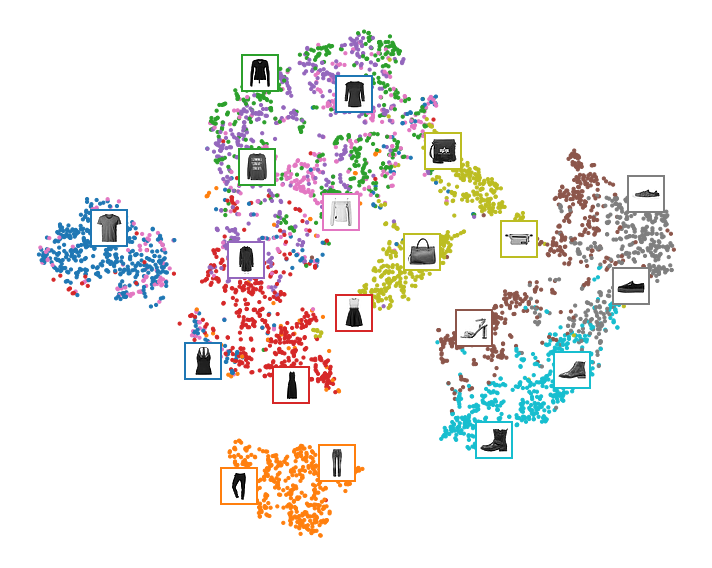

In [16]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

In [17]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

# 가중치 묶는 클래스        

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

# 가중치묶는 클래스

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# 가중치 묶는 층으로 디코더로 한다.

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3082 - val_rounded_accuracy: 0.9076
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2953 - val_rounded_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3017 - val_rounded_accuracy: 0.9087
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2872 - val_rounded_accuracy: 0.9317
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

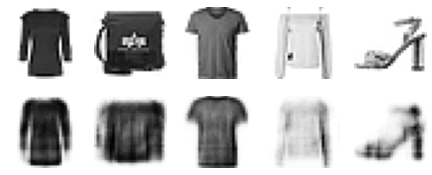

In [19]:
show_reconstructions(tied_ae)
plt.show()

# 가중치 인코더 결과 

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)
   

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================